In [4]:
import RNA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display

from collections import Counter
from collections import defaultdict
import subprocess
import difflib
import sys
import os
import random
import string
import time

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath


In [5]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # no scientific notation

# import feature_generation
from features import ij_distance, new_move_dist, plt_moves, config_distance, balance_in_all_things, return_shift_moves
from process_features import fp_call, find_moves, process

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## tf part

In [186]:
input_file = "move_diversity.csv"

dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="sequence", axis=1)
dataframe = dataframe.drop(labels="s2", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
# dataframe = dataframe.drop(labels="j", axis=1)
# dataframe = dataframe.drop(labels="found", axis=1)

dataframe

,j,target,en_mean,en_std,best_en
0,0.001667,0.166667,0.705833,0.077078,0.540
1,0.000000,0.000000,0.595000,0.126254,0.345
2,0.000000,0.000000,0.683611,0.102508,0.445
3,0.000000,0.000000,0.690588,0.079073,0.545
4,0.002000,0.200000,0.678000,0.032802,0.625
...,...,...,...,...,...
1528,0.000000,0.000000,0.656429,0.096943,0.430
1529,0.000000,0.000000,0.650833,0.096821,0.470
1530,0.000000,0.000000,0.680000,0.124479,0.415
1531,0.000000,0.000000,0.700000,0.077881,0.600


In [24]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# list(train["target"])
# list(train["j"])

102 train examples
26 validation examples
33 test examples


In [91]:
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

X.shape, y.shape

((40, 1), (40,))

In [92]:
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

X = np.array([test["j"]]).T
y = np.array(test["target"])

X,y
X.shape, y.shape


((33, 1), (33,))

## feature selection

## tf regression

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


input_file = "move_diversity.csv"
input_file = "move_diversity3.csv"
dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="sequence", axis=1)
dataframe = dataframe.drop(labels="s2", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
dataframe = dataframe.drop(labels="j", axis=1)

# dataframe = dataframe.drop(labels="vic", axis=1)
# dataframe = dataframe.drop(labels="vic_best", axis=1)

# dataframe = dataframe.drop(labels="unique_moves", axis=1)
# dataframe = dataframe.drop(labels="distlast", axis=1)

# dataframe = dataframe.drop(labels="found", axis=1)

dataframe

,target,en_mean,en_std,best_en,vic,vic_best,unique_moves,distlast
0,0.000000,0.671389,0.081237,0.500,1,1,0.166667,0.010
1,0.062500,0.665625,0.055702,0.540,0,0,0.200000,0.215
2,0.000000,0.525870,0.105456,0.365,0,0,0.166667,0.810
3,0.000000,0.696000,0.081388,0.645,0,0,0.500000,0.240
4,0.500000,0.661250,0.018498,0.645,0,0,0.500000,0.240
...,...,...,...,...,...,...,...,...
1010,0.000000,0.679706,0.097037,0.410,0,0,0.166667,0.020
1011,0.166667,0.720833,0.063765,0.620,0,0,0.250000,0.385
1012,0.277778,0.666389,0.071895,0.535,1,0,0.142857,0.180
1013,0.000000,0.627500,0.090898,0.440,1,1,0.250000,0.010


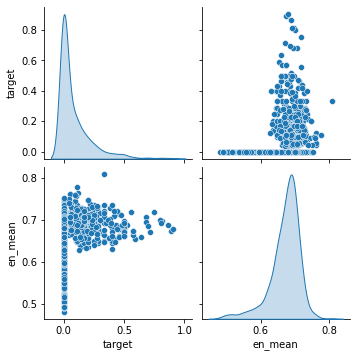

In [7]:
# sns.pairplot(dataframe[['target', 'best_en']], diag_kind='kde')
sns.pairplot(dataframe[['target', 'en_mean']], diag_kind='kde')

In [8]:
train_dataset = dataframe.sample(frac=0.8, random_state=0)
test_dataset = dataframe.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

train_features

# train_dataset.describe().transpose()[['mean', 'std']]



,en_mean,en_std,best_en,vic,vic_best,unique_moves,distlast
251,0.686250,0.126929,0.450,1,1,0.250000,0.010
75,0.701304,0.099206,0.515,1,0,0.166667,0.300
940,0.674286,0.059548,0.610,0,0,0.333333,0.145
691,0.495556,0.095071,0.340,0,0,0.111111,0.730
885,0.685000,0.090600,0.495,0,0,0.142857,0.020
...,...,...,...,...,...,...,...
464,0.676176,0.094892,0.520,1,0,0.142857,0.035
25,0.687500,0.115953,0.415,1,0,0.166667,0.215
110,0.694167,0.100557,0.570,0,0,0.500000,0.270
149,0.680500,0.090317,0.550,0,0,0.333333,0.125


In [11]:
# horsepower = np.array(train_features['en_mean'])

# horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
# horsepower_normalizer.adapt(horsepower)

# horsepower_model = tf.keras.Sequential([
#     horsepower_normalizer,
#     layers.Dense(units=1)
# ])

# horsepower_model.summary()
# horsepower_model.predict(horsepower[:10])

# horsepower_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')

# history = horsepower_model.fit(
# train_features['en_mean'],
# train_labels,
# epochs=100,
# # Suppress logging.
# verbose=1,
# # Calculate validation results on 20% of the training data.
# validation_split = 0.2)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# # history
# plot_loss(history)

In [10]:
# test_results = {}

# test_results['horsepower_model'] = horsepower_model.evaluate(
#     test_features['en_mean'],
#     test_labels, verbose=0)

# x = tf.linspace(0.0, 1, 2)
# y = horsepower_model.predict(x)

# def plot_horsepower(x, y):
#   plt.scatter(train_features['en_mean'], train_labels, label='Data')
#   plt.plot(x, y, color='k', label='Predictions')
#   plt.xlabel('en_mean')
#   plt.ylabel('MPG')
#   plt.legend()


# plot_horsepower(x,y)

## linear regression with multiple inputs

In [219]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_features))

# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(units=1)
# ])

# # linear_model.predict(train_features[:10])
# # linear_model.layers[1].kernel

# linear_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')

# history = linear_model.fit(
#     train_features,
#     train_labels,
#     epochs=100,
#     # Suppress logging.
#     # verbose=0,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)

# plot_loss(history)

In [220]:
# linear_model.evaluate(
#     test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 7)                 15        
_________________________________________________________________
dense_9 (Dense)              (None, 50)                400       
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 3,016
Trainable params: 3,001
Non-trainable params: 15
_________________________________________________________________
Epoch 1/200
21/21 [==============================] - 0s 7ms/step - loss: 0.1963 - val_loss: 0.1248
Epoch 2/200
21/21 

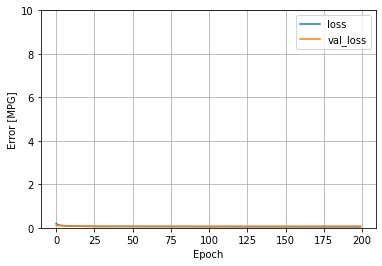

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(128, activation='relu'),
      # layers.Dense(128, activation='relu'),
      layers.Dense(50, activation='relu'),
      layers.Dense(50, activation='relu'),
      layers.Dropout(.2),
      # layers.Dropout(.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

plot_loss(history)

In [20]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

0.07027821987867355

In [24]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

data = {'en_mean': [0.678000],
        'en_std': 0.0328022,
        'best_en': 0.625,
        'vic': 0,
        'vic_best': 0,
        'unique_moves': 1,
        'distlast': 0.130}

test_features2 = pd.DataFrame.from_dict(data)
test_features2

,en_mean,en_std,best_en,vic,vic_best,unique_moves,distlast
0,0.678,0.032802,0.625,0,0,1,0.13


## Predictions

INFO:tensorflow:Assets written to: dnn_model/assets


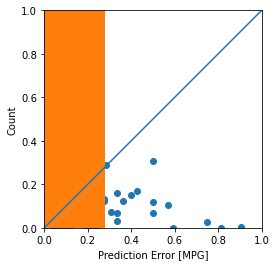

In [25]:
dnn_model.save('dnn_model')

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [23]:
test_predictions = dnn_model.predict(test_features).flatten()

for i, j in zip(test_labels, test_predictions):

    print (i, j)



0.0 0.00042047992
0.0 0.00042047992
0.1111111111111111 0.08633772
0.0 0.00042047992
0.2352941176470588 0.05591547
0.0 0.00042047992
0.0 0.00042047992
0.0 0.06624596
0.0909090909090909 0.12144191
0.1851851851851851 0.029546803
0.0 0.00042047992
0.2 0.10651467
0.0769230769230769 0.092570364
0.0 0.00042047992
0.1666666666666666 0.07362867
0.0666666666666666 0.059412915
0.0 0.00042047992
0.15 0.05709433
0.0 0.00042047992
0.1666666666666666 0.026563564
0.0 0.00042047992
0.0 0.00042047992
0.0 0.00042047992
0.0 0.00042047992
0.25 0.024886962
0.0 0.00042047992
0.2727272727272727 0.13367827
0.3333333333333333 0.15916547
0.0833333333333333 0.035276975
0.0 0.00042047992
0.0833333333333333 0.29819348
0.1111111111111111 0.097914875
0.0 0.00042047992
0.2857142857142857 0.29085895
0.0 0.00040776277
0.0 0.00042047992
0.0 0.029522676
0.0 0.00042047992
0.5909090909090909 0.0003380794
0.0 0.00042047992
0.0 0.00042047992
0.3076923076923077 0.07336634
0.0 0.00042047992
0.1111111111111111 0.09939818
0.07692